In [ ]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F
import os
import time
import copy
from PIL import Image

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    
}

data_dir=r'/content/drive/MyDrive/Human detection/preprocessed_data/preprocessed data'

image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=16)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(len(class_names))


2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])
8


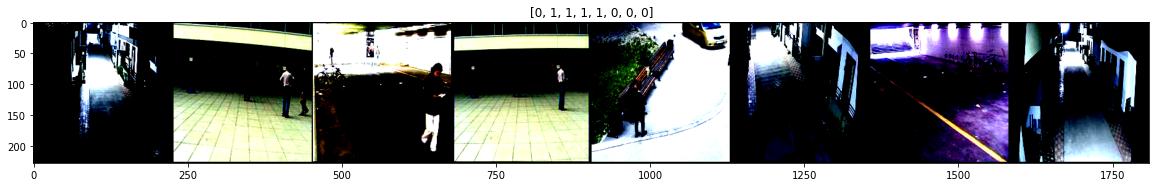

In [ ]:
#step 2 Visualizing the data
def view_data(loaded_data):
    batch=next(iter(loaded_data))
    images,labels=batch
    print(images.shape)
    print(images.shape[0])
    my_grid=torchvision.utils.make_grid(images,nrow=images.shape[0])
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(my_grid,(1,2,0)))
    plt.title([x.item() for x in labels])
view_data(dataloaders['train'])

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = torchvision.models.mobilenet_v2(pretrained=True)



In [ ]:
class_names=2
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, (class_names))

model_ft = model_ft.to(device)
#model_ft.load_state_dict(torch.load('./weights/resnet50.pt'))
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.003)



# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
def train_model( criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model_ft.state_dict())
    best_acc = 0.0
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model_ft.train()  # Set model to training mode
            else:
                model_ft.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward propagation.
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model_ft(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_ft.state_dict())

        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model_ft.load_state_dict(best_model_wts)
    return  [train_loss, train_acc, val_loss, val_acc]

In [ ]:
info = train_model(criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)


Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5845 Acc: 0.7396
val Loss: 0.7523 Acc: 0.6281
Epoch 1/29
----------
train Loss: 0.4828 Acc: 0.7942
val Loss: 0.4375 Acc: 0.7812
Epoch 2/29
----------
train Loss: 0.4395 Acc: 0.8126
val Loss: 0.5222 Acc: 0.8125
Epoch 3/29
----------
train Loss: 0.3796 Acc: 0.8446
val Loss: 0.3348 Acc: 0.8563
Epoch 4/29
----------
train Loss: 0.3855 Acc: 0.8403
val Loss: 0.2999 Acc: 0.8719
Epoch 5/29
----------
train Loss: 0.3608 Acc: 0.8583
val Loss: 0.4202 Acc: 0.8563
Epoch 6/29
----------
train Loss: 0.2977 Acc: 0.8791
val Loss: 0.1915 Acc: 0.9281
Epoch 7/29
----------
train Loss: 0.2471 Acc: 0.9068
val Loss: 0.1902 Acc: 0.9156
Epoch 8/29
----------
train Loss: 0.2242 Acc: 0.9180
val Loss: 0.1742 Acc: 0.9344
Epoch 9/29
----------
train Loss: 0.2141 Acc: 0.9230
val Loss: 0.2134 Acc: 0.9156
Epoch 10/29
----------
train Loss: 0.2144 Acc: 0.9263
val Loss: 0.2038 Acc: 0.9219
Epoch 11/29
----------
train Loss: 0.1861 Acc: 0.9331
val Loss: 0.1650 Acc: 0.9469
Epoch 12/29
----------
train Loss: 0

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/Human detection/mobilenetv2.pth')